In [1]:
%load_ext lab_black

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
import pandas as pd
import numpy as np

In [4]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import brier_score_loss, roc_auc_score

In [5]:
import lightgbm as lgb

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from weight_of_evidence import weight_of_evidence

In [8]:
import importlib

importlib.reload(weight_of_evidence)

<module 'weight_of_evidence.weight_of_evidence' from '/Users/olivercairns/Desktop/code/WeightOfEvidenceDemo/weight_of_evidence/weight_of_evidence.py'>

In [9]:
class NumCatEncoder(BaseEstimator, TransformerMixin):
    """
    Encodes string/object --> numeric categories

    Methods
    -------
        fit
            finds preprocessing strategies for all cols
        transform
            preprocesses all  cols
        fit_transform
            fit & transform
    """

    def fit(self, X, y=None):
        """
        Parameters
        ----------
            X : dataframe
                data to be encoded
        Returns
        ------
            self : BaseEstimator
                fitted transformer
        """
        self.categorical_cols_ = X.select_dtypes(include=["object"]).columns

        self.label_encoder = {}
        for cat_col in self.categorical_cols_:
            values = X[cat_col].astype("str").unique()
            mapping = dict(zip(values, range(len(values))))
            self.label_encoder[cat_col] = mapping

        return self

    def transform(self, X, y=None):
        """
        Parameters
        -----------
            X : dataframe
                data to be encoded
        Returns
        -------
            X : dataframe
                encoded data
        """
        _X = X.copy()
        for cat_col in self.categorical_cols_:
            _X[cat_col] = X[cat_col].astype("str").map(self.label_encoder[cat_col])

        return _X

In [10]:
class LightGBMCategoricalFeatureWrapper:
    def __init__(self, params={}):
        self.params = params
        self.encoder = NumCatEncoder()

    def fit(self, X, y):
        X_encoded = self.encoder.fit_transform(X)
        cat_col_idxs = [i for i, d_type in enumerate(X.dtypes) if d_type == "object"]

        lgb_train = lgb.Dataset(
            data=X_encoded, label=y, categorical_feature=cat_col_idxs
        )

        self.lgb_classifier = lgb.train(params=self.params, train_set=lgb_train)
        return self

    def predict_proba(self, X):
        X_encoded = self.encoder.transform(X)
        p_1 = self.lgb_classifier.predict(X_encoded)
        p_0 = 1.0 - p_1
        return np.stack([p_0, p_1]).T

In [11]:
data = pd.read_csv("~/Downloads/application_train.csv")

In [12]:
EXCLUDE_COLS = [
    "SK_ID_CURR",
    "TARGET",
    "CODE_GENDER",
    "ORGANIZATION_TYPE",
    "NAME_FAMILY_STATUS",
]

In [13]:
CATERORICAL_COLS = data.drop(columns=EXCLUDE_COLS).select_dtypes("O").columns

In [14]:
NUMERIC_COLS = data.drop(columns=EXCLUDE_COLS).select_dtypes("int64").columns

In [15]:
data[CATERORICAL_COLS] = data[CATERORICAL_COLS].fillna("MISSING")

In [16]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

In [17]:
ohe_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUMERIC_COLS),
        ("cat", OneHotEncoder(handle_unknown="ignore"), CATERORICAL_COLS),
    ]
)

In [18]:
log_reg = LogisticRegression(solver="lbfgs", max_iter=1e6)

In [19]:
ohe_logit = Pipeline(
    steps=[("preprocessor", ohe_preprocessor), ("log_reg_classifier", log_reg),]
)

In [21]:
lgb_baseline = LightGBMCategoricalFeatureWrapper()

In [22]:
combined_results = pd.DataFrame()

In [23]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

In [24]:
X = data.drop(columns=EXCLUDE_COLS)
y = data.TARGET

In [25]:
def get_cv_results(X, y, cv, clf, model_name):
    results = {"auc": [], "fold": []}
    fold = 1
    for train, test in cv.split(X, y):
        print(f"fold {fold}")
        prediction = clf.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        try:
            auc = roc_auc_score(y_true=y.iloc[test], y_score=prediction[:, 1])
        except:
            from IPython import embed

            embed()
        results["auc"].append(auc)
        results["fold"].append(fold)
        print(f"auc {auc}")
        fold += 1
    results_df = pd.DataFrame(results)
    results_df["model"] = model_name
    return results_df

In [26]:
combined_results = get_cv_results(X, y, cv, ohe_logit, "ohe logit")

fold 1
auc 0.660356832255731
fold 2
auc 0.6631419031153942
fold 3
auc 0.6540158169998416
fold 4
auc 0.6600730788975613
fold 5
auc 0.6668053062809923


In [27]:
combined_results.groupby("model")[["auc"]].mean()

,auc
model,
ohe logit,0.660879


In [28]:
combined_results = combined_results.append(
    get_cv_results(X, y, cv, lgb_baseline, "lightgbm")
)

fold 1


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


auc 0.7477476261454079
fold 2


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


auc 0.7515870409775942
fold 3


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


auc 0.756963598293098
fold 4


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


auc 0.7563320126820852
fold 5


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


auc 0.7544231628224962


In [29]:
combined_results.groupby("model")[["auc"]].mean()

,auc
model,
lightgbm,0.753411
ohe logit,0.660879


In [30]:
woebin_logit = Pipeline(
    steps=[
        ("tree_bin", weight_of_evidence.TreeBinner()),
        ("woe_scale", weight_of_evidence.LogitScaler()),
        ("standard_scale", StandardScaler()),
        ("log_reg_classifier", log_reg),
    ]
)

In [31]:
combined_results = combined_results.append(
    get_cv_results(X, y, cv, woebin_logit, "woe binned logit")
)

fold 1
auc 0.7318989461659113
fold 2
auc 0.733909088329558
fold 3
auc 0.7380581255765258
fold 4
auc 0.7396356094087767
fold 5
auc 0.7365325216092035


In [32]:
combined_results.groupby("model")[["auc"]].mean()

,auc
model,
lightgbm,0.753411
ohe logit,0.660879
woe binned logit,0.736007


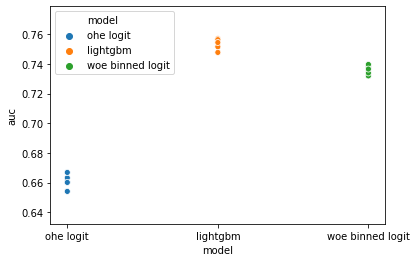

In [33]:
sns.scatterplot(data=combined_results, x="model", y="auc", hue="model")

In [34]:
woebin_logit.fit(X, y)

Pipeline(memory=None,
         steps=[('tree_bin',
                 TreeBinner(max_depth=None, min_gini_decrease=None,
                            min_samples_per_node=None)),
                ('woe_scale', LogitScaler(clip_thresh=100000.0)),
                ('standard_scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('log_reg_classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000000.0,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [35]:
def plot_feature_importance(
    var_names, coefficients, n=10, output_dir=None, verbose=True
):
    """
    Find logit regression feature importance
    Args:
        var_names (series): variable names
        coefficients (series): regression coefficients
        n (integer): how many features to plot
    """
    coef_df = pd.DataFrame()
    coef_df["var_names"] = var_names
    coef_df["coef_vals"] = coefficients
    coef_df["abs_vals"] = np.abs(coef_df.coef_vals)
    coef_df = coef_df.set_index("var_names").sort_values(by="abs_vals", ascending=True)
    if verbose:
        plt.figure(figsize=(4, 8))
        ax = coef_df.tail(n).coef_vals.plot.barh()
        plt.title(f"Top {n} features - logistic regression \n")
        plt.show()
    return coef_df.reset_index()

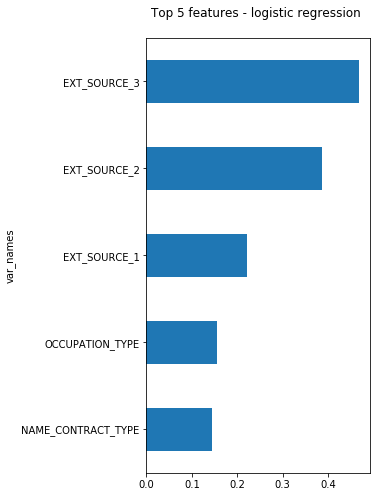

In [36]:
var_importance = plot_feature_importance(
    X.columns, woebin_logit["log_reg_classifier"].coef_[0], n=5
)

In [37]:
top_5 = var_importance.tail(5).var_names[::-1]

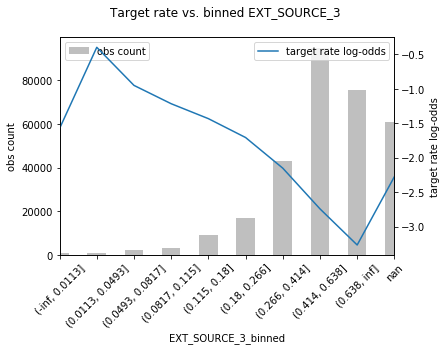

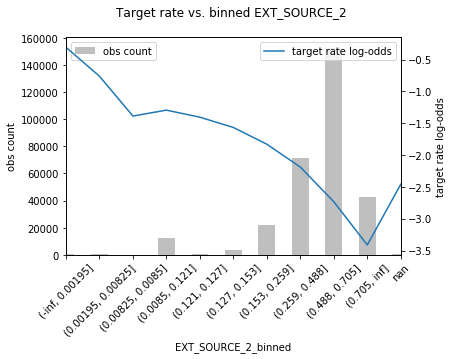

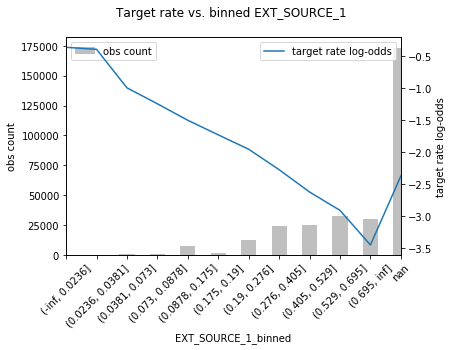

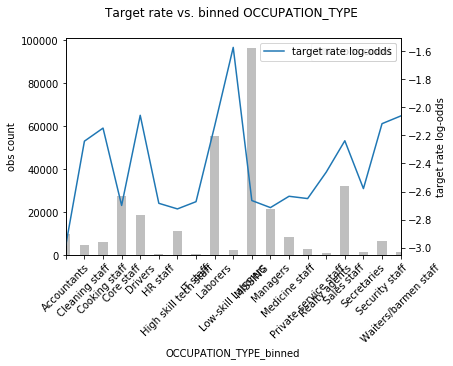

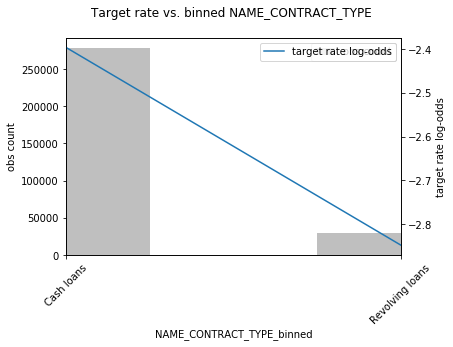

In [47]:
weight_of_evidence.plot_bins(
    X[top_5], y, woebin_logit["tree_bin"].splits_, space="log-odds"
)

In [39]:
first = X.head(1)

In [40]:
first.T

,0
NAME_CONTRACT_TYPE,Cash loans
FLAG_OWN_CAR,N
FLAG_OWN_REALTY,Y
CNT_CHILDREN,0
AMT_INCOME_TOTAL,202500
...,...
AMT_REQ_CREDIT_BUREAU_DAY,0
AMT_REQ_CREDIT_BUREAU_WEEK,0
AMT_REQ_CREDIT_BUREAU_MON,0
AMT_REQ_CREDIT_BUREAU_QRT,0


In [41]:
first_encoded = woebin_logit["standard_scale"].transform(
    woebin_logit["woe_scale"].transform(woebin_logit["tree_bin"].transform(first))
)

In [42]:
first_encoded

array([[ 3.24395321e-01,  7.17913542e-01, -6.64531393e-01,
         1.00000000e+00,  1.00000000e+00,  4.44912583e-03,
         6.36360419e-03,  1.54474123e+00,  3.32563583e-01,
         9.76680573e-03,  5.56612792e-01, -2.74514376e-01,
         3.28709988e-01,  1.35551868e+00,  6.70176869e-01,
         5.87632117e-01,  9.31099760e-01,  4.40497693e-01,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.17245042e+00,  2.55026953e-03, -4.31824041e-01,
        -4.07867971e-01,  4.60977715e-01,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         3.04495015e+00,  6.90361211e-01,  2.05652645e+00,
         6.28163624e-01, -1.18767224e+00, -9.75910451e-01,
        -1.40885669e+00, -1.52289339e+00, -2.21351960e-01,
        -1.00699986e+00,  5.29581271e-01, -4.95204410e-01,
        -1.20898460e+00,  4.05060389e-01,  6.64627538e-0

In [43]:
woebin_logit["log_reg_classifier"].predict_proba(first_encoded)

array([[0.40257974, 0.59742026]])

In [44]:
y.mean()

0.08072881945686496

In [45]:
first_importance = first_encoded * woebin_logit["log_reg_classifier"].coef_

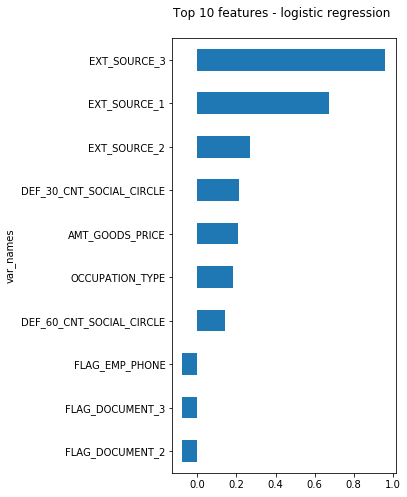

In [46]:
importance_cols = plot_feature_importance(X.columns, first_importance[0], n=10)